<a href="https://colab.research.google.com/github/SahelKherad/3-story-benchmark-transformer/blob/main/09_04(2_sensor_9_state_splitGap%3Ewindow).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [253]:
import os
import scipy.io
from scipy.io.matlab._mio5_params import mat_struct
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [254]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [255]:
!ls "/content/drive/My Drive/ASCE"

shm01a.mat  shm03a.mat	shm05a.mat  shm07a.mat	shm09a.mat
shm02a.mat  shm04a.mat	shm06a.mat  shm08a.mat


In [256]:
def load_mat(path):
    mat = scipy.io.loadmat(path, squeeze_me=True, struct_as_record=False)
    raw = mat.get('dasy')
    if isinstance(raw, mat_struct):
        channels = []
        for f in raw._fieldnames:
            arr = getattr(raw, f)
            channels.append(np.asarray(arr).reshape(-1))
        data = np.stack(channels, axis=1)  # (n_samples, n_channels)
    else:
        raise ValueError("Unexpected MAT structure. 'dasy' not a struct.")
    return data  # float64 by default

base_dir = '/content/drive/MyDrive/ASCE/'
state_files = {
    1: 'shm01a.mat', 2: 'shm02a.mat', 3: 'shm03a.mat',
    4: 'shm04a.mat', 5: 'shm05a.mat', 6: 'shm06a.mat',
    7: 'shm07a.mat', 8: 'shm08a.mat', 9: 'shm09a.mat',
}
# label_to_class_id: 1..9 -> 0..8
label_to_cid = {lab: i for i, lab in enumerate(sorted(state_files.keys()))}

scenario_data = {}   # cid -> np.ndarray [N, C]
for lab, fname in state_files.items():
    x = load_mat(os.path.join(base_dir, fname)).astype(np.float32)
    scenario_data[label_to_cid[lab]] = x

In [257]:
# 4) Choose the 5 scenarios and the 4 sensors you care about
chosen_scenario = {
    "healthy": 0,    # shm01a.mat
    "dam1":    1,    # shm02a.mat
    "dam2":    2,    # shm03a.mat
    "dam3":    3,    # shm04a.mat
    "dam4":    4,    # shm05a.mat
    "dam5":    5,    # shm06a.mat
    "dam6":    6,    # shm07a.mat
    "dam7":    7,    # shm08a.mat
    "dam8":    8,    # shm09a.mat
   }
sensor_cols = [3,4,5,6,7,8,9,10,11,12,13,14]

In [258]:
win = 512
stride = 512

In [259]:
def select_sensors(arr, cols):
  return arr[:, cols]

In [260]:
healthy = select_sensors(scenario_data[0], sensor_cols)
dam1 = select_sensors(scenario_data[1], sensor_cols)
dam2 = select_sensors(scenario_data[2], sensor_cols)
dam3 = select_sensors(scenario_data[3], sensor_cols)
dam4 = select_sensors(scenario_data[4], sensor_cols)
dam5 = select_sensors(scenario_data[5], sensor_cols)
dam6 = select_sensors(scenario_data[6], sensor_cols)
dam7 = select_sensors(scenario_data[7], sensor_cols)
dam8 = select_sensors(scenario_data[8], sensor_cols)

In [261]:
# state1=10000 * select_sensors(scenario_data[0], sensor_cols)
# print(state1)
# state2=10000 * select_sensors(scenario_data[1], sensor_cols)
# print(state2)

In [262]:
def chrono_split_with_gap(W, train_frac=0.6, val_frac=0.2, gap_windows=5):

    n = len(W)
    n_train = int(train_frac * n)
    n_val   = int(val_frac * n)

    # train indices: from start to n_train-1
    train_idx = np.arange(0, n_train)

    # val starts after a gap
    val_start = n_train + gap_windows
    val_end   = val_start + n_val
    val_end   = min(val_end, n)  # safety

    val_idx = np.arange(val_start, val_end)

    # test starts after another gap
    test_start = val_end + gap_windows
    test_idx   = np.arange(test_start, n)

    W_train = W[train_idx]
    W_val   = W[val_idx]
    W_test  = W[test_idx]

    return W_train, W_val, W_test


In [263]:
gap = 10  # number of windows to skip between splits

tr_0, va_0, te_0 = chrono_split_with_gap(healthy, gap_windows=gap)
tr_1, va_1, te_1 = chrono_split_with_gap(dam1, gap_windows=gap)
tr_2, va_2, te_2 = chrono_split_with_gap(dam2, gap_windows=gap)
tr_3, va_3, te_3 = chrono_split_with_gap(dam3, gap_windows=gap)
tr_4, va_4, te_4 = chrono_split_with_gap(dam4, gap_windows=gap)
tr_5, va_5, te_5 = chrono_split_with_gap(dam5, gap_windows=gap)
tr_6, va_6, te_6 = chrono_split_with_gap(dam6, gap_windows=gap)
tr_7, va_7, te_7 = chrono_split_with_gap(dam7, gap_windows=gap)
tr_8, va_8, te_8 = chrono_split_with_gap(dam8, gap_windows=gap)

print("Train rows per class:", [len(tr_0), len(tr_1), len(tr_2), len(tr_3), len(tr_4), len(tr_5), len(tr_6), len(tr_7), len(tr_8)])
print("Val   rows per class:", [len(va_0), len(va_1), len(va_2), len(va_3), len(va_4), len(va_5), len(va_6), len(va_7), len(va_8)])
print("Test  rows per class:", [len(te_0), len(te_1), len(te_2), len(te_3), len(te_4), len(te_5), len(te_6), len(te_7), len(te_8)])

Train rows per class: [36000, 36000, 36000, 36000, 36000, 27340, 108000, 108000, 108000]
Val   rows per class: [12000, 12000, 12000, 12000, 12000, 9113, 36000, 36000, 36000]
Test  rows per class: [11980, 11980, 11980, 11980, 11980, 9095, 35980, 35980, 35980]


In [264]:
con = np.concatenate([tr_0, tr_1, tr_2, tr_3, tr_4, tr_5, tr_6, tr_7, tr_8], axis = 0)
print(con.shape)
mu = con. mean(axis =(0), keepdims = True)
print(mu.shape)
print(mu)
std = con.std(axis = (0), keepdims = True)+ 1e-6

(531340, 1)
(1, 1)
[[-0.00071259]]


In [265]:
# gap = 1  # number of rows to skip between splits

# tr_0, va_0, te_0 = chrono_split_with_gap(state1, gap_windows=gap)
# tr_1, va_1, te_1 = chrono_split_with_gap(state2, gap_windows=gap)

In [266]:
# tr_0, va_0, te_0

In [267]:
# tr_1, va_1, te_1

In [268]:
# con = np.stack((tr_0, tr_1), axis=0)
# print('con\n',con)
# mu = con. mean(axis =(0,1), keepdims = True)
# print(mu.shape)
# print('mu',mu)
# std = con.std(axis=(0,1), keepdims=True) + 1e-6
# print('std',std)

In [269]:
def z_score(data, mu,std):
  return (data - mu) / std

In [270]:
tr_0 = z_score(tr_0, mu, std)
va_0 = z_score(va_0, mu, std)
te_0 = z_score(te_0, mu, std)

tr_1 = z_score(tr_1, mu, std)
va_1 = z_score(va_1, mu, std)
te_1 = z_score(te_1, mu, std)

tr_2 = z_score(tr_2, mu, std)
va_2 = z_score(va_2, mu, std)
te_2 = z_score(te_2, mu, std)

tr_3 = z_score(tr_3, mu, std)
va_3 = z_score(va_3, mu, std)
te_3 = z_score(te_3, mu, std)

tr_4 = z_score(tr_4, mu, std)
va_4 = z_score(va_4, mu, std)
te_4 = z_score(te_4, mu, std)

tr_5 = z_score(tr_5, mu, std)
va_5 = z_score(va_5, mu, std)
te_5 = z_score(te_5, mu, std)

tr_6 = z_score(tr_6, mu, std)
va_6 = z_score(va_6, mu, std)
te_6 = z_score(te_6, mu, std)

tr_7 = z_score(tr_7, mu, std)
va_7 = z_score(va_7, mu, std)
te_7 = z_score(te_7, mu, std)

tr_8 = z_score(tr_8, mu, std)
va_8 = z_score(va_8, mu, std)
te_8 = z_score(te_8, mu, std)

In [271]:
def window(x, length_win=5, stride=4):
    N = len(x)
    if len(x) < length_win:
        return np.empty((0, length_win), dtype=x.dtype)
    n = (len(x) - length_win) // stride + 1
    idxs = np.arange(length_win)[None, :] + stride * np.arange(n)[:, None]
    return x[idxs]

In [272]:
train_0 = window (tr_0, length_win=win, stride = stride)
train_1 = window (tr_1, length_win=win, stride = stride)
train_2 = window (tr_2, length_win=win, stride = stride)
train_3 = window (tr_3, length_win=win, stride = stride)
train_4 = window (tr_4, length_win=win, stride = stride)
train_5 = window (tr_5, length_win=win, stride = stride)
train_6 = window (tr_6, length_win=win, stride = stride)
train_7 = window (tr_7, length_win=win, stride = stride)
train_8 = window (tr_8, length_win=win, stride = stride)

val_0 = window (va_0, length_win = win, stride = stride)
val_1 = window (va_1, length_win = win, stride = stride)
val_2 = window (va_2, length_win = win, stride = stride)
val_3 = window (va_3, length_win = win, stride = stride)
val_4 = window (va_4, length_win = win, stride = stride)
val_5 = window (va_5, length_win = win, stride = stride)
val_6 = window (va_6, length_win = win, stride = stride)
val_7 = window (va_7, length_win = win, stride = stride)
val_8 = window (va_8, length_win = win, stride = stride)

test_0 = window(te_0, length_win = win, stride = stride)
test_1 = window(te_1, length_win = win, stride = stride)
test_2 = window(te_2, length_win = win, stride = stride)
test_3 = window(te_3, length_win = win, stride = stride)
test_4 = window(te_4, length_win = win, stride = stride)
test_5 = window(te_5, length_win = win, stride = stride)
test_6 = window(te_6, length_win = win, stride = stride)
test_7 = window(te_7, length_win = win, stride = stride)
test_8 = window(te_8, length_win = win, stride = stride)


In [273]:
# train_0, train_1, train_2, train_3, train_4, train_5, train_6, train_7, train_8

In [274]:
# train_0 = window (tr_0, length_win=2, stride = 2)
# train_1 = window (tr_1, length_win=2, stride = 2)
# train_0, train_1


In [275]:
X_train = np.concatenate([train_0, train_1, train_2, train_3, train_4, train_5, train_6, train_7, train_8])
X_val   = np.concatenate([val_0, val_1, val_2, val_3, val_4, val_5, val_6, val_7, val_8])
X_test  = np.concatenate([test_0, test_1, test_2, test_3, test_4, test_5, test_6, test_7, test_8])

y_train = np.concatenate([np.full(len(train_0), 0), np.full(len(train_1), 1), np.full(len(train_2), 2), np.full(len(train_3), 3), np.full(len(train_4), 4),
                          np.full(len(train_5), 5), np.full(len(train_6), 6), np.full(len(train_7), 7), np.full(len(train_8), 8)], axis = 0)

y_val   = np.concatenate([np.full(len(val_0), 0), np.full(len(val_1), 1), np.full(len(val_2), 2), np.full(len(val_3), 3), np.full(len(val_4), 4),
                          np.full(len(val_5), 5), np.full(len(val_6), 6), np.full(len(val_7), 7), np.full(len(val_8), 8)], axis= 0)

y_test = np.concatenate([ np.full(len(test_0), 0), np.full(len(test_1), 1), np.full(len(test_2), 2), np.full(len(test_3), 3), np.full(len(test_4), 4),
                          np.full(len(test_5), 5), np.full(len(test_6), 6), np.full(len(test_7), 7), np.full(len(test_8), 8)], axis=0)

In [276]:
# X_train = (X_train - mu) / std
# X_val   = (X_val   - mu) / std
# X_test  = (X_test  - mu) / std


In [277]:
rng = np.random.default_rng(42)
idx = rng.permutation(len(X_train))
X_train = X_train[idx]
y_train = y_train[idx]

In [278]:
X_train = torch.from_numpy(X_train).float()
X_val   = torch.from_numpy(X_val).float()
X_test  = torch.from_numpy(X_test).float()
y_train = torch.from_numpy(y_train).long()
y_val   = torch.from_numpy(y_val).long()
y_test  = torch.from_numpy(y_test).long()

In [279]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

torch.Size([1033, 512, 1]) torch.Size([1033])
torch.Size([342, 512, 1]) torch.Size([342])
torch.Size([342, 512, 1]) torch.Size([342])


In [280]:
class SeqDataset(Dataset):
    def __init__(self, X: torch.Tensor, y: torch.Tensor):
        self.X = X.float()  # [N, seq_len, 1]
        self.y = y.long()  # [N]
    def __len__(self): return self.y.shape[0]
    def __getitem__(self, i): return self.X[i], self.y[i]

train_ds = SeqDataset(X_train, y_train)
print(X_train.shape)
# print(train_ds[0])
# print(train_ds[1])
# print(train_ds[2])
val_ds   = SeqDataset(X_val,   y_val)
test_ds  = SeqDataset(X_test,  y_test)

torch.Size([1033, 512, 1])


In [281]:
# 6) DataLoaders: shuffle only the training set
batch_size = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

In [282]:
with torch.no_grad():
    ys_tr = torch.cat([yb.view(-1) for _, yb in train_loader], dim=0).cpu()
    ys_va = torch.cat([yb.view(-1) for _, yb in val_loader], dim=0).cpu()
    ys_te = torch.cat([yb.view(-1) for _, yb in test_loader], dim=0).cpu()


print("train label set/counts:", ys_tr.unique(return_counts=True))
print("val   label set/counts:", ys_va.unique(return_counts=True))
print("test  label set/counts:", ys_te.unique(return_counts=True))
print("train min/max:", ys_tr.min().item(), ys_tr.max().item())
print("val   min/max:", ys_va.min().item(), ys_va.max().item())

train label set/counts: (tensor([0, 1, 2, 3, 4, 5, 6, 7, 8]), tensor([ 70,  70,  70,  70,  70,  53, 210, 210, 210]))
val   label set/counts: (tensor([0, 1, 2, 3, 4, 5, 6, 7, 8]), tensor([23, 23, 23, 23, 23, 17, 70, 70, 70]))
test  label set/counts: (tensor([0, 1, 2, 3, 4, 5, 6, 7, 8]), tensor([23, 23, 23, 23, 23, 17, 70, 70, 70]))
train min/max: 0 8
val   min/max: 0 8


In [283]:
class LearnablePositionalEncoding(nn.Module):
    """
    Learnable positional encoding added to token embeddings.
    Shape stored: [1, max_len, d_model]
    """
    def __init__(self, d_model: int, max_len: int):
        super().__init__()
        self.pe = nn.Parameter(torch.zeros(1, max_len, d_model))
        print(self.pe)
        nn.init.trunc_normal_(self.pe, std=0.02)

    def forward(self, x):
        # x: [B, T, d_model]
        T = x.size(1)
        return x + self.pe[:, :T, :]

In [284]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, d_model=256, nhead=4, num_layers=3, d_ff=256, seq_len= X_train.shape[1], num_classes=3, dropout=0.1):
        super().__init__()
        self.inp = nn.Linear(1, d_model)                            # project feature_dim=1 -> d_model
        self.pos = LearnablePositionalEncoding(d_model, seq_len)    # learnable PE
        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead,
            dim_feedforward=d_ff, dropout=dropout,
            batch_first=True                                        # so we keep [B, T, d]
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, num_classes)

    def forward(self, x):
        # x: [B, T, 1]
        x = self.inp(x)                  # [B, T, d]
        x = self.pos(x)                  # add learnable PE
        x = self.encoder(x)              # [B, T, d]
        x = self.norm(x)
        x = x.mean(dim=1)                # mean pool over time

        logits = self.head(x)            # [B, C]
        return logits

In [285]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seq_len = X_train.shape[1]
num_classes = 9
model = TimeSeriesTransformer(
    d_model=16,
    nhead=2,
    num_layers=4,
    d_ff=16,
    seq_len=seq_len ,
    num_classes=9,
    dropout=0.1).to(device)

Parameter containing:
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], requires_grad=True)


In [286]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device) # Move the model to the selected device

Using device: cuda


TimeSeriesTransformer(
  (inp): Linear(in_features=1, out_features=16, bias=True)
  (pos): LearnablePositionalEncoding()
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
        )
        (linear1): Linear(in_features=16, out_features=16, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=16, out_features=16, bias=True)
        (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
  (head): Linear(in_features=16, out_features=9, bias=True)
)

In [287]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

loss_fn = nn.CrossEntropyLoss()

In [288]:
num_epochs = 100
tr_losses, tr_accs, val_losses, val_accs = [], [], [], []

for epoch in range(num_epochs):
     model.train()
     total_loss, total_samples, correct_predictions = 0, 0, 0
     for xb, yb in train_loader:
        xb , yb = xb.to(device) , yb.to(device).long()
        optimizer.zero_grad()
        output = model(xb)
        # print('output',output)
        # print('max',torch.max(output, 1))
        # print('yb',yb)

        loss = loss_fn(output , yb)
        # print('loss',loss)
        # optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
        # print(loss.item())
        # print(xb.size(0))
        # print('total:',total_loss)

        # Calculate accuracy
        pred = output.argmax(dim=1) # the index of the maximum value for each column
        # print('p',predicted)
        # print('real',yb)
        total_samples += xb.size(0)
        # print(total_samples)
        correct_predictions += (pred == yb).sum().item()
        # print(correct_predictions)

     epoch_loss = total_loss / total_samples
     epoch_accuracy = correct_predictions / total_samples
     tr_losses.append(epoch_loss)
     tr_accs.append(epoch_accuracy)

    #  print(f"Epoch {epoch+1}/{num_epochs}: " f"Train Loss: {epoch_loss:.4f}, "f"Train Accuracy: {epoch_accuracy:.4f}")

     model.eval()
     val_correct_predictions , val_total_samples , val_total_loss = 0 , 0 , 0

     with torch.no_grad():
          for xb, yb in val_loader:
              xb, yb = xb.to(device), yb.to(device).long()
              output = model(xb)
              val_loss = loss_fn(output,yb)
              val_total_loss += val_loss.item() * xb.size(0)
              pred = output.argmax(dim=1)
              val_total_samples += xb.size(0)
              val_correct_predictions += (pred == yb).sum().item()

     val_epoch_loss = val_total_loss / val_total_samples
     val_epoch_accuracy = val_correct_predictions / val_total_samples
    #  print(    f"Validation Loss: {val_epoch_loss:.4f}, "f"Validation Accuracy: {val_epoch_accuracy:.4f}\n")
     val_losses.append(val_epoch_loss)
     val_accs.append(val_epoch_accuracy)
     # 3) Step the scheduler once per epoch, after validation
    #  scheduler.step()

     # Optional: print current lr to confirm schedule
     current_lr = optimizer.param_groups[0]["lr"]
     print(f"Epoch {epoch+1}/{num_epochs}: " f"Train Loss: {epoch_loss:.4f}, "f"Train Accuracy: {epoch_accuracy:.4f} | "f"Validation Loss: {val_epoch_loss:.4f}, "f"Validation Accuracy: {val_epoch_accuracy:.4f}\n")




Epoch 1/30: Train Loss: 2.0136, Train Accuracy: 0.1994 | Validation Loss: 1.7988, Validation Accuracy: 0.2719

Epoch 2/30: Train Loss: 1.7204, Train Accuracy: 0.3156 | Validation Loss: 1.5524, Validation Accuracy: 0.4766

Epoch 3/30: Train Loss: 1.4736, Train Accuracy: 0.4947 | Validation Loss: 1.3128, Validation Accuracy: 0.4766

Epoch 4/30: Train Loss: 1.2749, Train Accuracy: 0.4743 | Validation Loss: 1.1821, Validation Accuracy: 0.4766

Epoch 5/30: Train Loss: 1.1595, Train Accuracy: 0.4956 | Validation Loss: 1.0953, Validation Accuracy: 0.4766

Epoch 6/30: Train Loss: 1.0902, Train Accuracy: 0.5005 | Validation Loss: 1.0367, Validation Accuracy: 0.6813

Epoch 7/30: Train Loss: 1.0377, Train Accuracy: 0.5663 | Validation Loss: 0.9882, Validation Accuracy: 0.6111

Epoch 8/30: Train Loss: 0.9846, Train Accuracy: 0.6350 | Validation Loss: 0.9430, Validation Accuracy: 0.8158

Epoch 9/30: Train Loss: 0.9415, Train Accuracy: 0.6941 | Validation Loss: 0.9015, Validation Accuracy: 0.8158

E

In [289]:
import torch.nn.functional as F
val_probs = []
val_true  = []
with torch.no_grad():
    for xb, yb in val_loader:
        out = model(xb.to(device))
        val_probs.append(F.softmax(out, dim=1).max(1).values.cpu())
        val_true.append(yb)
val_probs = torch.cat(val_probs)
print('Val avg max-softmax:', val_probs.mean().item())

Val avg max-softmax: 0.718625545501709


In [290]:
from sklearn.metrics import confusion_matrix
import numpy as np
all_pred, all_true = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        out = model(xb.to(device))
        all_pred.append(out.argmax(1).cpu().numpy())
        all_true.append(yb.numpy())
cm = confusion_matrix(np.concatenate(all_true), np.concatenate(all_pred))
print(cm)

[[23  0  0  0  0  0  0  0  0]
 [ 0 23  0  0  0  0  0  0  0]
 [ 0  0 23  0  0  0  0  0  0]
 [ 0  0  0 23  0  0  0  0  0]
 [23  0  0  0  0  0  0  0  0]
 [ 0  4  0  0  0 13  0  0  0]
 [ 0  0  0  0  0  0 70  0  0]
 [ 0  0  0  0  0  0  0 70  0]
 [ 0  0  0  0  0  0  0  0 70]]


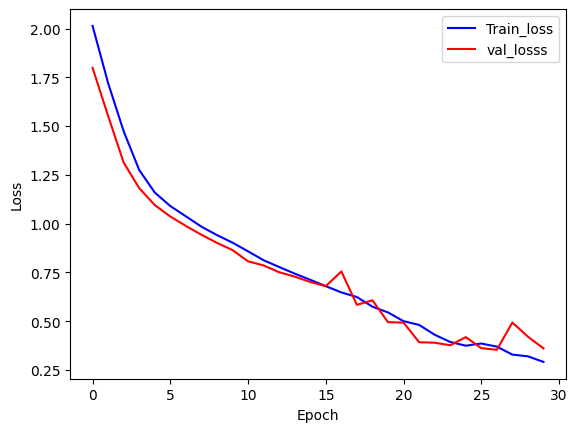

In [291]:
epoch = np.arange(0,num_epochs , 1)
import matplotlib.pyplot as plt

plt.plot(epoch, tr_losses , label="Train_loss", c='b')
plt.plot(epoch, val_losses, label="val_losss", c='r')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [292]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

model.eval()
all_true = []
all_pred = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        out = model(xb)
        pred = out.argmax(dim=1).cpu().numpy()
        all_pred.append(pred)
        all_true.append(yb.numpy())

y_true = np.concatenate(all_true)
y_pred = np.concatenate(all_pred)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)

# Accuracy
acc = accuracy_score(y_true, y_pred)

# Precision, recall, F1 (macro average over 9 classes)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_true, y_pred, average='macro', zero_division=0
)

print("Accuracy:", acc)
print("Precision (macro):", prec)
print("Recall (macro):", rec)
print("F1 (macro):", f1)

[[23  0  0  0  0  0  0  0  0]
 [ 0 23  0  0  0  0  0  0  0]
 [ 0  0 23  0  0  0  0  0  0]
 [ 0  0  0 23  0  0  0  0  0]
 [23  0  0  0  0  0  0  0  0]
 [ 0 17  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 70  0  0]
 [ 0  0  0  0  0  0  0 69  1]
 [ 0  0  0  0  0  0  0  0 70]]
Accuracy: 0.8801169590643275
Precision (macro): 0.673435054773083
Recall (macro): 0.7761904761904762
F1 (macro): 0.7091709948488355


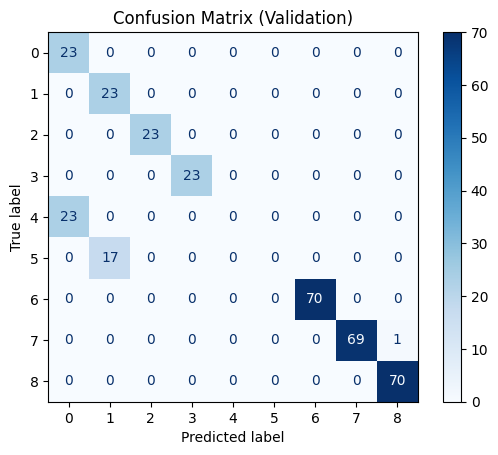

In [293]:
import torch
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
import matplotlib.pyplot as plt

y_true, y_pred, y_score = [], [], []
model.eval()

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device).long()   # targets should be int for CE
        logits = model(xb)                             # [B, num_classes]

        # 1) Probability of class 1
        # For multiclass ROC/PR, you'd typically get scores for each class
        probs  = torch.softmax(logits, dim=1)          # [B, num_classes]
        # y_score is currently only storing probabilities for class 1
        # To plot multiclass ROC/PR, you'd need probabilities for all classes
        # and adapt the plotting functions or use a one-vs-rest approach.
        score1 = probs[:, 1]                           # [B]

        # 2) Predicted class index
        preds  = logits.argmax(dim=1)                  # [B]

        # Save results
        y_true.extend(yb.cpu().tolist())
        y_pred.extend(preds.cpu().tolist())
        y_score.extend(score1.cpu().tolist()) # Storing scores for class 1 only

# 1) Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Validation)")
plt.show()

# The following lines are commented out because they are designed for binary classification
# and will raise a ValueError for multiclass targets (0, 1, 2).
# To plot ROC or Precision-Recall for multiclass, a one-vs-rest strategy is typically used,
# which would involve binarizing y_true for each class and providing corresponding class probabilities.

# # 2) ROC
# RocCurveDisplay.from_predictions(y_true, y_score)
# plt.title("ROC Curve (Validation)")
# plt.show()

# # 3) Precision–Recall
# PrecisionRecallDisplay.from_predictions(y_true, y_score)
# plt.title("Precision–Recall Curve (Validation)")
# plt.show()

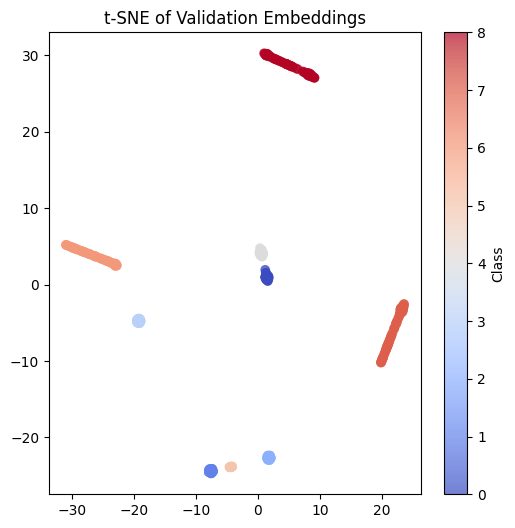

In [294]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch

model.eval()
all_embeds, all_labels = [], []

with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        # Pass through encoder only (skip classifier head)
        embeds = model.encoder(model.inp(xb) + model.pos(model.inp(xb)))
        embeds = embeds.mean(dim=1)                # [B, d_model]

        all_embeds.append(embeds.cpu())
        all_labels.append(yb.cpu())

# Concatenate all batches
all_embeds = torch.cat(all_embeds, dim=0).numpy()
all_labels = torch.cat(all_labels, dim=0).numpy()

# Run t-SNE
X_2d = TSNE(n_components=2, random_state=42).fit_transform(all_embeds)

# Plot
plt.figure(figsize=(6,6))
plt.scatter(X_2d[:,0], X_2d[:,1], c=all_labels, cmap="coolwarm", alpha=0.7)
plt.colorbar(label="Class")
plt.title("t-SNE of Validation Embeddings")
plt.show()